### Evaluating the Effect of Time Bin Size on Learned Tunings calculate based on REM periods' firings
##### This Jupyter notebook explores the effect of time bin size on the learned tunings that are calculated based on neuronal population activity during REM periods. Specifically, we will investigate how the size of the time bin used for the analysis affects fidelity of the learned tunings to the correspondong place fields.

##### We will perform this analysis on a dataset of neural recordings from rats during REM sleep periods. We will use different time bin sizes to calculate the population vectors, and compare the resulting learned tunings to determine the optimal time bin size for this dataset.


In [ ]:
import os
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from learned_tuning.learned_tuning import calculate_place_field_fidelity_of_learned_tuning, calculate_all_column_correlations

%matplotlib widget


def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.std(x) # the function to calculate z-score
p_score = lambda x: 100 * np.sum(x <= x[i]) / len(x)

normalize_to_max = lambda x:(x/np.nanmax(x))


# load REM learned tunings calculated using MATLAB

main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
rr = os.listdir(main_dir)

current_sessions = [x for x in range(17) if x not in (12, 13)] # RatV sessions for now and Roy familiar sessions were excluded

epoch_names = ['pre', 'post']

bin_durations = [0.02, 0.05, 0.125, 0.25, 0.5, 1, 2] # bin sizes used for calculation of REM learned tunings


number_of_sessions = len(current_sessions)
num_units = np.empty((number_of_sessions,), dtype=int)
each_unit_session_number = np.empty((number_of_sessions,), dtype=object)

spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE


learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)

gw = gausswindow(3, 9) # for smoothing the tunings 


for session_idx in range(number_of_sessions):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]

    print(session_name + " " + str(session_idx+1) + "/" + str(number_of_sessions))

    session_dataset_path = os.path.join(main_dir, session_name)


    """
    spatial tunings during MAZE and reMAZE
    """

    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
    
    if session_number in [6, 7]: # RatN and RatS
        num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0] # for RatN only
    else:
        num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]



    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size

    
    spikes = []; # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'LR', 'RL', 'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['peak_pos_bins_maze'] = {}

        for direction in running_directions:
            try:
                if session_number in [6, 7]:    
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['peak_pos_bins_maze'][direction] = spikes_pyr['peakPosBin'][0][unit][direction][0][0][0][0]

            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1


        spikes.append(unit_spikes) 

        """
        MAZE spatial tunings / place fields
        """


    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)

    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    # peak_place_field_fr = np.full((num_units_total,), np.nan)

    for unit in range(len(spikes)):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        # peak_place_field_fr[unit] = spikes[unit]['peak_firing_rate']['uni']

        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze[session_idx][unit] = spatial_tuning_maze_curr_unit

        # spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)
        # spatial_tunings_maze[session_idx][unit] = normalize_to_max(spatial_tuning_maze_curr_unit) 

    active_units = np.where(np.nanmax(spatial_tunings_maze[session_idx], axis=1) > 1)[0]
    # active_units = np.where(peak_place_field_fr > 1)[0]
    num_units[session_idx] = len(active_units)
    
    spatial_tunings_maze[session_idx] = np.apply_along_axis(normalize_to_max, 1, spatial_tunings_maze[session_idx])


    spatial_tunings_maze[session_idx] = spatial_tunings_maze[session_idx][active_units]
    spatial_tunings_maze[session_idx][np.isnan(spatial_tunings_maze[session_idx])] = 1e-16



    """
    Loading REM learned tunings using different bin sizes
    """
    learned_tunings_curr_session = dict()
    condition_names = []
    for i_bin, bin_dur in enumerate(bin_durations):
        mat_file = loadmat(os.path.join(session_dataset_path, 'NREM_REM_', session_name +  f".assemblyTunings_REM_{bin_dur:.3f}.mat"))
        for epoch in epoch_names:
            curr_conditions = f'{epoch}_{bin_dur:0.3f}'
            condition_names.append(curr_conditions)
            learned_tunings_curr_session[curr_conditions] = mat_file["assemblyTunings"][epoch].item()['data'].item()

    condition_names = np.sort(condition_names)

    learned_tunings[session_idx] = dict()
    learned_tunings_place_field_corr[session_idx] = dict()
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict()
    num_shuffles = 10000
    for cond_idx, condition in enumerate(condition_names):

        learned_tunings[session_idx][condition] = np.full((num_units[session_idx].item(), num_pos_bins_interp), np.nan)

        for unit in range(num_units[session_idx].item()):
            curr_unit_learned_tuning = learned_tunings_curr_session[condition][active_units[unit]].reshape(num_pos_bins)
            curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')

            # Normalize
            # learned_tunings[session_idx][epoch_name][unit] = z_score(curr_unit_learned_tuning)
            learned_tunings[session_idx][condition][unit] = normalize_to_max(curr_unit_learned_tuning)

        # recalculate the correlation between learned tunings and MAZE place fields
        (learned_tunings_place_field_corr[session_idx][condition],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][condition],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][condition],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )

    each_unit_session_number[session_idx] = np.full((num_units[session_idx],), session_number)



In [130]:
# concatenate place fields from all sessions and sort them according to the peak place field locations

spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)
place_fields_peak_locations = np.argmax(spatial_tunings_maze_sessions_concat, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)

spatial_tunings_maze_sessions_concat = spatial_tunings_maze_sessions_concat[place_fields_sort_idx]

# place_field_stability_maze_concat = np.concatenate(place_field_stability_maze, axis=0)
# place_field_stability_maze_concat = place_field_stability_maze_concat[place_fields_sort_idx]

each_unit_session_number_sessions_concat = np.concatenate(each_unit_session_number, axis=0)
each_unit_session_number_sessions_concat = each_unit_session_number_sessions_concat[place_fields_sort_idx]


# learned tunings
learned_tunings_sessions_concat = dict.fromkeys(condition_names)
learned_tunings_place_field_population_vector_correlation = dict.fromkeys(condition_names)
for condition in condition_names:
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][condition])
    learned_tunings_sessions_concat[condition] = np.concatenate(temp, axis = 0)
    learned_tunings_sessions_concat[condition] = learned_tunings_sessions_concat[condition][place_fields_sort_idx]

    # population vector correlation between the learned tunings and the place fields
    learned_tunings_place_field_population_vector_correlation[condition] = calculate_all_column_correlations(learned_tunings_sessions_concat[condition], spatial_tunings_maze_sessions_concat)


learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(condition_names)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(condition_names)
learned_tunings_place_field_corr_p_values_concat = dict.fromkeys(condition_names)
lt_pf_correlation_median_across_all_sessions = dict.fromkeys(condition_names)
lt_pf_correlation_median_across_all_sessions_pvalue = dict.fromkeys(condition_names)

for condition in condition_names:
    # data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][condition])
    learned_tunings_place_field_corr_sessions_concat[condition] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]
    # learned_tunings_place_field_corr_sessions_concat[condition] = learned_tunings_place_field_corr_sessions_concat[condition][place_fields_sort_idx]

    # shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][condition])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[condition] = np.concatenate(temp, axis = 0)[place_fields_sort_idx]
    # learned_tunings_place_field_corr_unit_id_shuffle_concat[condition] = learned_tunings_place_field_corr_unit_id_shuffle_concat[condition][place_fields_sort_idx]

    # calculate the p-values of place fidelities
    lt_pf_correlation_median_across_all_sessions[condition] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[condition])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[condition], axis = 0)

    lt_pf_correlation_median_across_all_sessions_pvalue[condition] = np.sum(ui_lt_pf_correlation_medians >= lt_pf_correlation_median_across_all_sessions[condition])/num_shuffles



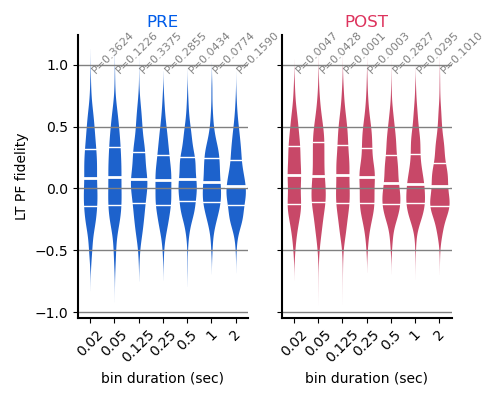

In [147]:
def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        pvalue_statement = 'P<1e-4'
    else:
        pvalue_statement = f'P={pvalue:.4f}'
    return pvalue_statement

colors = [
    '#005CE9',  # PRE
    '#DD335D'  # POST
]

# Split dictionary by epoch
pre_pf_fidelities_different_bin_sizes = {k: v for k, v in learned_tunings_place_field_corr_sessions_concat.items() if k.startswith('pre')}
pre_median_p_values_different_bin_sizes = {k:v for k, v in lt_pf_correlation_median_across_all_sessions_pvalue.items() if k.startswith('pre')}

post_pf_fidelities_different_bin_sizes = {k: v for k, v in learned_tunings_place_field_corr_sessions_concat.items() if k.startswith('post')}
post_median_p_values_different_bin_sizes = {k:v for k, v in lt_pf_correlation_median_across_all_sessions_pvalue.items() if k.startswith('post')}


# Create figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(5, 4), sharey=True)

# Define a function to plot violin plots
def plot_violin(ax, data, color):
    alpha = 1
    sns.violinplot(data=list(data.values()), ax=ax, color=color, inner='quartiles', linewidth=0)
    for violin, curr_alpha in zip(ax.collections[::2], [alpha] * 5):
        violin.set_alpha(curr_alpha)
    for l in ax.lines:
        l.set_linestyle('-')
        l.set_linewidth(1)
        l.set_color('white')
        l.set_alpha(1)
    for l in ax.lines[1::3]:
        l.set_linestyle('-')
        l.set_linewidth(2)
        l.set_color('white')
        l.set_alpha(1)
    ax.set_xticklabels(bin_durations, rotation=45, ha='center')
    ax.grid(axis='y', color='gray', linewidth=1)
    for axis in ['left', 'bottom']:
        ax.spines[axis].set_linewidth(1.5)


# Plot distributions for pre-epoch conditions
plot_violin(axs[0], pre_pf_fidelities_different_bin_sizes, colors[0])

# Add p-values for each violin
for i, (condition, data) in enumerate(pre_pf_fidelities_different_bin_sizes.items()):
    p_val = pre_median_p_values_different_bin_sizes[condition]
    axs[0].text(i, 0.75 * axs[0].get_ylim()[1], get_pval_statement(p_val), ha='left', fontsize=8, rotation=45, color='gray')

axs[0].set_xlabel('bin duration (sec)')
axs[0].set_ylabel('LT PF fidelity')
axs[0].set_title('PRE', color=colors[0])

# Plot distributions for post-epoch conditions
plot_violin(axs[1], post_pf_fidelities_different_bin_sizes, colors[1])

# Add p-values for each violin
for i, (condition, data) in enumerate(post_pf_fidelities_different_bin_sizes.items()):
    p_val = post_median_p_values_different_bin_sizes[condition]
    axs[1].text(i, 0.75 * axs[1].get_ylim()[1], get_pval_statement(p_val), ha='left', fontsize=8, rotation=45, color='gray')

axs[1].set_xlabel('bin duration (sec)')
axs[1].set_title('POST', color=colors[1])

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
sns.despine()

filename = 'REM_learned_tunings_different_bin_sizes.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)
plt.show()
